# Feature Selection Experimentos - Attack

In [1]:
!pip install shap
!pip install catboost
!pip install Lightgbm
!pip install eli5
!pip install pdp
!pip install pdpbox
import sys
#!pip install pandas-profiling

     |████████████████████████████████| 358kB 7.5MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491623 sha256=07c0efa242adc55052bc3e1f3e7b91ba4296e84ea76961cb255d50c526a7fe30
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 69.2MB 40kB/s 
     |████████████████████████████████| 112kB 8.3MB/s 
  Created wheel for pdp: filename=pdp-0.3.0-cp37-none-any.whl size=6620 sha256=61cc4a9f8424e7a3dd1e8ddd7d6ca4d96edc5b07cc176138f082043230bb2ebc
  Stored in directory: /root/.cache/pip/wheels/84/fb/5e/afb783110614b3c1a4187e6f83e4f4ea0088fbdb82921013a2
Successfully built pdp
     |████████████████████████████████| 34.0MB 89kB/s 
     |████████████████████████████████| 13.1MB 242kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-cp37-none-any.whl size=35758227 sha256=c2fb47753085bdf2f92d0d4f5bbb5bfc50ec76bbe2da7a44bd43f3457155de32
  Stor

## Incorporación de Toolbox

In [2]:
#Revisando DataSet de NUSW-NB15
import shap
import pandas as pd
import numpy as np
import io
import seaborn as sn
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from google.colab import files, drive
from sklearn.metrics import roc_curve, auc #for lgbfit evaluation
from sklearn.metrics import classification_report #for lgbfit evaluation
from sklearn.metrics import confusion_matrix #for lgbfit evaluation
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, info_plots #for partial plots
np.random.seed(123) #ensure reproducibility
from sklearn.ensemble import RandomForestClassifier #for the model


import numpy as np
import pandas as pd
import lightgbm as lgb
import graphviz as graphviz

pd.options.mode.chained_assignment = None  #hide any pandas warnings

## Lectura de Datos en Google Drive

In [3]:

drive.mount('/gdrive')
 
#Abriendo ruta donde subi los Dataset
%cd '/gdrive/My Drive/Colab Notebooks/DataSet/Entrenamiento'
 
#Listo ficheros subidos al directorio
!ls     

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/DataSet/Entrenamiento
a.png			     encoder_no_compress.png
autoencoder_compress.png     modelo.png
autoencoder.h5		     model.png
autoencoder_no_compress.png  rf_individualtree.png
encoder_compress.png	     UNSW_NB15_testing-set.csv
encoder.h5		     UNSW_NB15_training-set.csv


In [7]:
df = pd.read_csv('UNSW_NB15_training-set.csv', sep=',')
df_test = pd.read_csv('UNSW_NB15_testing-set.csv', sep=',')


df_total = pd.concat([df,df_test])
df_total = df_total[df_total.label != 0] #jugar con los dos att (!= 1) y no att(!= 0)



y_category = df_total['attack_cat'].astype('category').values
LE_category = LabelEncoder()
y_total = LE_category.fit_transform(y_category)
y_attack = df_total['label'].values

#Eliminado algunos campos del dataframe  ('id','label', 'attack_cat','is_sm_ips_ports')
df_total = df_total.drop(['id','label', 'attack_cat','is_sm_ips_ports'], axis = 1)

df_total.columns = ['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes','rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss','dloss','sinpkt','dinpkt','sjit','djit','swin','stcpb','dtcpb','dwin','tcprtt','synack','ackdat','smean','dmean','trans_depth','response_body_len','ct_srv_src','ct_state_ttl','ct_dst_ltm','ct_src_dport_ltm','ct_dst_sport_ltm','ct_dst_src_ltm','is_ftp_login','ct_ftp_cmd','ct_flw_http_mthd','ct_src_ltm','ct_srv_dst']


#Modificando las variables categoricas con la F. LabelEncoder()
LE_proto = LabelEncoder()
df_total['proto'] = LE_proto.fit_transform(df_total['proto'])
LE_service = LabelEncoder()
df_total['service'] = LE_service.fit_transform(df_total['service'])
LE_state = LabelEncoder()
df_total['state'] = LE_state.fit_transform(df_total['state'])
X_real = df_total.values

# Estandariza las características eliminando la media y escalando a la varianza de la unidad
scaler = StandardScaler()
#Calcula la media y la estándar que se utilizarán para escalar posteriormente.
scaler.fit(X_real)

#Realiza la estandarización centrando y escalando
X_total = scaler.transform(X_real)

#X_total = X_real
n_classes = np.max(y_total)+1
y = np_utils.to_categorical(y_total)
X = X_total.astype(float)
y2 = np_utils.to_categorical(y_total)
X2 = X_total.astype(float)



In [ ]:
df_total.dtypes

dur                  float64
proto                  int64
service                int64
state                  int64
spkts                  int64
dpkts                  int64
sbytes                 int64
dbytes                 int64
rate                 float64
sttl                   int64
dttl                   int64
sload                float64
dload                float64
sloss                  int64
dloss                  int64
sinpkt               float64
dinpkt               float64
sjit                 float64
djit                 float64
swin                   int64
stcpb                  int64
dtcpb                  int64
dwin                   int64
tcprtt               float64
synack               float64
ackdat               float64
smean                  int64
dmean                  int64
trans_depth            int64
response_body_len      int64
ct_srv_src             int64
ct_state_ttl           int64
ct_dst_ltm             int64
ct_src_dport_ltm       int64
ct_dst_sport_l

In [ ]:
dt = pd.get_dummies(df_total, drop_first=True)

In [ ]:
dt

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst
47911,0.000009,19,0,4,2,0,200,0,111111.107200,254,0,8.888889e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,100,0,0,0,4,2,1,1,1,4,0,0,0,2,4
47912,0.000009,50,0,4,2,0,200,0,111111.107200,254,0,8.888889e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,100,0,0,0,7,2,2,2,2,7,0,0,0,2,7
47913,0.000009,11,0,4,2,0,200,0,111111.107200,254,0,8.888889e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,100,0,0,0,6,2,1,1,1,6,0,0,0,1,6
47914,0.000003,124,0,4,2,0,200,0,333333.321500,254,0,2.666667e+08,0.000000,0,0,0.003000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,100,0,0,0,6,2,2,2,2,7,0,0,0,2,6
47915,0.000008,84,0,4,2,0,200,0,125000.000300,254,0,1.000000e+08,0.000000,0,0,0.008000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,100,0,0,0,4,2,1,1,1,4,0,0,0,11,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65847,0.000012,115,0,4,2,0,1510,0,83333.330390,254,0,5.033333e+08,0.000000,0,0,0.012000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,755,0,0,0,7,2,1,1,1,1,0,0,0,1,5
65848,20.542910,115,0,4,4,0,1216,0,0.146036,254,0,3.551590e+02,0.000000,0,0,6847.637500,0.000000,9684.009000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,304,0,0,0,8,2,1,1,1,1,0,0,0,1,6
65849,20.542910,115,0,4,4,0,1216,0,0.146036,254,0,3.551590e+02,0.000000,0,0,6847.637500,0.000000,9684.009000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,304,0,0,0,8,2,1,1,1,1,0,0,0,1,6
65850,0.627022,109,0,3,10,6,590,268,23.922605,254,252,6.774882e+03,2857.953857,2,1,69.669111,110.819797,3539.085239,187.036922,255,3355187755,3247085936,255,0.126341,0.072123,0.054218,59,45,0,0,5,1,2,1,1,1,0,0,0,1,5


Epoch 1/100
7205/7205 - 44s - loss: 0.0054 - val_loss: 0.0010
Epoch 2/100
7205/7205 - 42s - loss: 0.0014 - val_loss: 7.7813e-04
Epoch 3/100
7205/7205 - 44s - loss: 0.0011 - val_loss: 5.4763e-04
Epoch 4/100
7205/7205 - 42s - loss: 9.1582e-04 - val_loss: 0.0014
Epoch 5/100
7205/7205 - 44s - loss: 8.1063e-04 - val_loss: 7.1758e-04
Epoch 6/100
7205/7205 - 42s - loss: 7.5091e-04 - val_loss: 3.1411e-04
Epoch 7/100
7205/7205 - 43s - loss: 6.6339e-04 - val_loss: 6.7159e-04
Epoch 8/100
7205/7205 - 42s - loss: 6.3248e-04 - val_loss: 4.2267e-04
Epoch 9/100
7205/7205 - 42s - loss: 5.8750e-04 - val_loss: 3.6921e-04
Epoch 10/100
7205/7205 - 42s - loss: 5.7882e-04 - val_loss: 8.0079e-04
Epoch 11/100
7205/7205 - 43s - loss: 5.4377e-04 - val_loss: 4.7474e-04
Epoch 12/100
7205/7205 - 43s - loss: 5.4068e-04 - val_loss: 4.8577e-04
Epoch 13/100
7205/7205 - 43s - loss: 5.1537e-04 - val_loss: 4.7851e-04
Epoch 14/100
7205/7205 - 42s - loss: 4.8755e-04 - val_loss: 3.8842e-04
Epoch 15/100
7205/7205 - 43s - loss

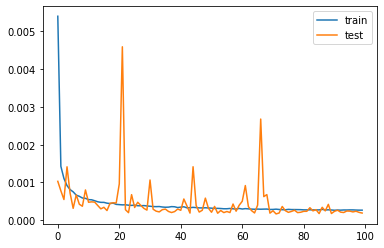

In [8]:
# train autoencoder for classification with with compression in the bottleneck layer
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
# define dataset

# number of input columns
n_inputs = X.shape[1]
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)
# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
#################################################
# bottleneck
n_bottleneck = 10 #2;5;8;10;12;15;20
bottleneck = Dense(n_bottleneck)(e)
#################################################
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='nadam', loss='mse') #mse cross entropy sigmoid cross entropy #nadam loss="binary_crossentropy"
# plot the autoencoder
plot_model(model, 'autoencoder_compress.png', show_shapes=True)
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=100, batch_size=16, verbose=2, validation_data=(X_test,X_test)) # batch_size=32; 64;128;256;512
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder_compress.png', show_shapes=True)
# save the encoder to file
encoder.save('encoder.h5')

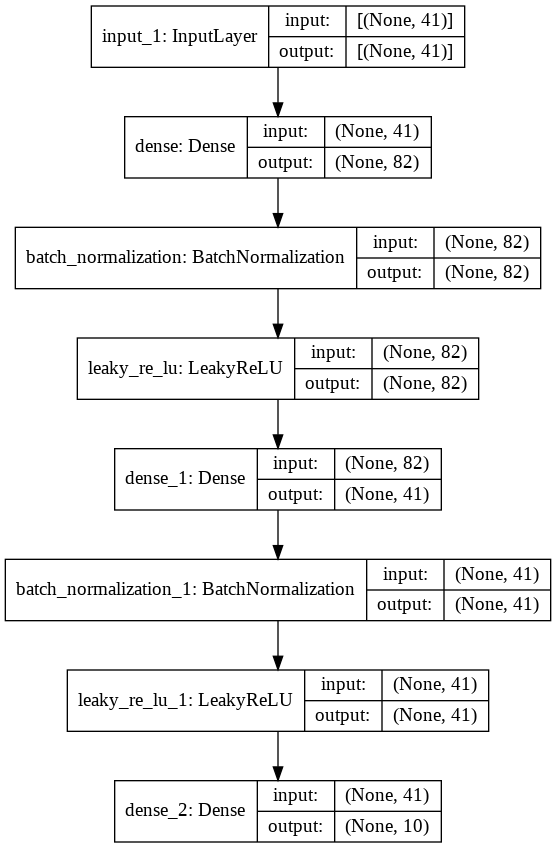

In [ ]:
from tensorflow.keras.utils import plot_model
# define an encoder model (without the decoder)
plot_model(encoder, 'a.png', show_shapes=True)

In [ ]:
y_pred = encoder.predict(X_test)
print("Predicción:", y_pred[30])

Predicción: [  4.6623716  -14.52187     -0.7532874   -4.060497     8.582549
 -14.20553      3.8208911  -11.817389    -0.13030478  -6.2959466 ]


In [10]:
# evaluate logistic regression on encoded input
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model


# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)


# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

# load the model from file
encoder2 = load_model('encoder.h5')

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.33)


X_train.shape

(110330, 41)

In [12]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier


# encode the train data
X_train_encode = encoder2.predict(X_train)
# encode the test data
X_test_encode = encoder2.predict(X_test)
# define the model


#model = LogisticRegression()
# fit the model on the training set

#model = tree.DecisionTreeClassifier() #0.6456397328082734

#model = RandomForestClassifier(max_depth=2, random_state=0) #0.4169626262812138
#model = RandomForestClassifier(max_depth=8, random_state=1) #0.565831845867913
#model = RandomForestClassifier(max_depth=9) 0.583515816204479
#model = ExtraTreesClassifier() #0.6538468616013102
#model = ExtraTreesClassifier(n_estimators=100, random_state=0) #0.6549877629133467
#model = RandomForestClassifier(n_estimators=100, max_features="auto",random_state=0) #0.6596801795999485
#model = RandomForestClassifier() #0.6608026792779199
#model = RandomForestClassifier(n_estimators=500, max_depth=4)

model = RandomForestClassifier()

#model = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=5, gamma=0.8, subsample=0.8, colsample_bytree=0.8, objective= "binary:logistic", nthread=4, scale_pos_weight=1)

model.fit(X_train_encode, y_train )
# make predictions on the test set
yhat = model.predict(X_test_encode)
# calculate classification accuracy
print(accuracy_score(y_test, yhat))

0.6864913604328065


In [ ]:
X_train_encode

array([[ -6.096889  ,  -2.674365  ,   2.3000598 , ..., -11.933441  ,
         -5.848022  ,  -5.6272717 ],
       [  9.094065  ,  -4.960257  ,   9.646845  , ...,  -1.362289  ,
         23.381977  ,   2.6966457 ],
       [ -4.23529   ,   1.8532696 ,   3.5994744 , ...,  -9.707774  ,
         -0.27061513,  -5.182593  ],
       ...,
       [ -2.5022671 ,   2.9720054 ,   5.159813  , ...,  -9.544991  ,
          2.9577641 ,  -4.9249287 ],
       [  1.8215134 ,   4.6171756 ,  -3.5066614 , ...,   8.159829  ,
        -19.511938  ,   9.146326  ],
       [ -4.7077675 ,   1.2863005 ,   6.2271743 , ...,  -8.144022  ,
          1.3729548 ,  -4.8539944 ]], dtype=float32)

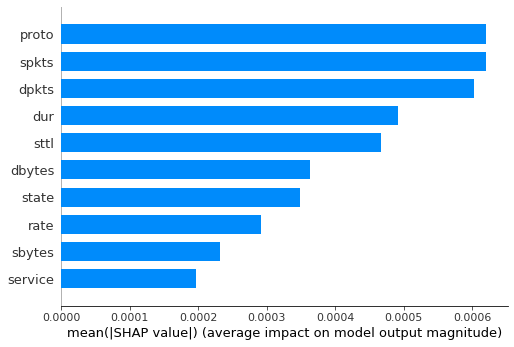

In [13]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_encode[0:200])

shap.summary_plot(shap_values[1], X_test_encode[0:200], plot_type="bar", feature_names= df_total.columns)

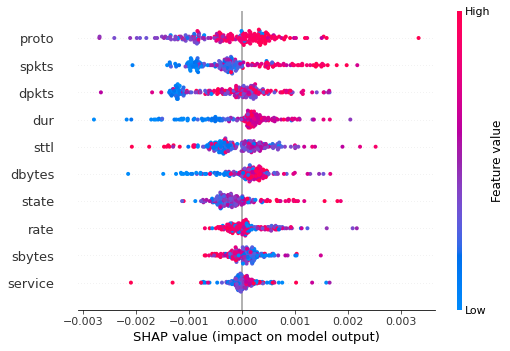

In [14]:
shap.summary_plot(shap_values[1], X_test_encode[0:200], feature_names= df_total.columns)

In [15]:
def evaluacionAtaque(model, ata):

    explainer = shap.TreeExplainer(model, feature_names= df_total.columns)
    shap_values = explainer.shap_values(ata)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1])

In [16]:
data_for_prediction = X_test_encode[5,:].astype(float)
evaluacionAtaque(model, data_for_prediction)

In [17]:
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier


# encode the train data
X_train_encode = encoder2.predict(X_train)
# encode the test data
X_test_encode = encoder2.predict(X_test)
# define the model

model2 = RandomForestClassifier()

#model2 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=5, gamma=0.8, subsample=0.8, colsample_bytree=0.8, objective= "binary:logistic", nthread=4, scale_pos_weight=1)

model2.fit(X_train, y_train)
# make predictions on the test set
yhat = model2.predict(X_test)
# calculate classification accuracy
print(accuracy_score(y_test, yhat))

0.7352188874372044


In [ ]:
explainer = shap.TreeExplainer(model2)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values[1], X_test)

In [ ]:
data_for_prediction = X_test_encode[1,:].astype(float)
evaluacionAtaque(model2, data_for_prediction, features_display)

In [ ]:
data_for_prediction = X_test_encode[3,:].astype(float)
evaluacionAtaque(model2, data_for_prediction, features_display)

In [ ]:
y_train.shape #Tamaño


(110330, 9)